In [27]:
%pip install yfinance, pandas

ERROR: Invalid requirement: 'yfinance,': Expected end or semicolon (after name and no valid version specifier)
    yfinance,
            ^
Note: you may need to restart the kernel to use updated packages.


In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Data Collection and Preparation

## Get FTSE MIB Data

In [29]:

ftse = yf.download('FTSEMIB.MI', start='2010-01-01', end='2025-01-01')
print(ftse.head())

/var/folders/vx/vjd7552x5l3gdz4mv0ql3sd00000gn/T/ipykernel_58122/4080209599.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ftse = yf.download('FTSEMIB.MI', start='2010-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker     FTSEMIB.MI FTSEMIB.MI FTSEMIB.MI FTSEMIB.MI FTSEMIB.MI
Date                                                             
2010-01-04    23545.0    23545.0    23317.0    23360.0  409066900
2010-01-05    23556.0    23654.0    23480.0    23554.0  520893900
2010-01-06    23622.0    23634.0    23484.0    23580.0  307231300
2010-01-07    23709.0    23756.0    23467.0    23551.0  593410300
2010-01-08    23811.0    23911.0    23668.0    23816.0  670146800


Get VSTOXX from 2010 to 2025, downloaded from (Marketwatch)[https://www.marketwatch.com/investing/index/v2tx/download-data?startDate=1/1/2010&endDate=1/1/2025&countryCode=xx]

In [30]:
vstoxx = pd.read_csv('INDEX_XX_XSTX_V2TX.csv')

print(vstoxx.head())

         Date   Open   High    Low  Close
0  12/30/2024  17.05  17.00  17.00  17.00
1  12/27/2024  17.35  16.27  16.27  16.27
2  12/23/2024  17.85  17.19  17.19  17.19
3  12/20/2024  19.07  16.84  16.84  16.84
4  12/19/2024  16.85  18.63  18.63  18.63


## Compute Returns for FTSE MIB Index

In [31]:
ftse = ftse.sort_index()
close_prices = ftse['Close']['FTSEMIB.MI']

ftse_returns = close_prices.pct_change().dropna()

print(ftse_returns)


Date
2010-01-05    0.000467
2010-01-06    0.002802
2010-01-07    0.003683
2010-01-08    0.004302
2010-01-11   -0.001512
                ...   
2024-12-19   -0.017848
2024-12-20   -0.000622
2024-12-23   -0.000770
2024-12-27    0.012478
2024-12-30    0.000732
Name: FTSEMIB.MI, Length: 3809, dtype: float64


## Compute Returns for VSTOXX (Euro STOXX 50 Volatility Index)

In [32]:
vstoxx['Date'] = pd.to_datetime(vstoxx['Date'])
vstoxx = vstoxx.sort_values('Date')

vstoxx.set_index('Date', inplace=True)
vstoxx_returns = vstoxx['Close'].pct_change().dropna()

print(vstoxx_returns)

Date
2010-01-04   -0.022860
2010-01-05   -0.016163
2010-01-06   -0.006485
2010-01-07   -0.012620
2010-01-08   -0.031291
                ...   
2024-12-19    0.283058
2024-12-20   -0.096082
2024-12-23    0.020784
2024-12-27   -0.053519
2024-12-30    0.044868
Name: Close, Length: 3842, dtype: float64


## Split into training and testing set

In [33]:
returns = pd.DataFrame({
    'FTSE_MIB': ftse_returns,
    'VSTOXX': vstoxx_returns
})
returns.index = pd.to_datetime(returns.index)
train_returns = returns[(returns.index >= '2010-01-01') & (returns.index <= '2023-12-31')]
test_returns = returns[(returns.index >= '2024-01-01') & (returns.index <= '2025-12-31')]


In [34]:
print(train_returns)

            FTSE_MIB    VSTOXX
Date                          
2010-01-04       NaN -0.022860
2010-01-05  0.000467 -0.016163
2010-01-06  0.002802 -0.006485
2010-01-07  0.003683 -0.012620
2010-01-08  0.004302 -0.031291
...              ...       ...
2023-12-21 -0.002866  0.066719
2023-12-22  0.002609 -0.002208
2023-12-27  0.002273  0.042773
2023-12-28 -0.002991 -0.043847
2023-12-29  0.000692  0.003698

[3607 rows x 2 columns]


In [35]:
print(test_returns)

            FTSE_MIB    VSTOXX
Date                          
2024-01-02  0.005700  0.067797
2024-01-03 -0.013890  0.069013
2024-01-04  0.010066 -0.076178
2024-01-05  0.001217 -0.013277
2024-01-08  0.004238 -0.008499
...              ...       ...
2024-12-19 -0.017848  0.283058
2024-12-20 -0.000622 -0.096082
2024-12-23 -0.000770  0.020784
2024-12-27  0.012478 -0.053519
2024-12-30  0.000732  0.044868

[254 rows x 2 columns]


# Markowitz Portfolio Construction

## Estimate Covariance Dynamically

In [36]:
window_size = 60
rolling_covariances = train_returns.rolling(window=window_size).cov()
rolling_covariances = rolling_covariances.dropna()

print(rolling_covariances)

                     FTSE_MIB    VSTOXX
Date                                   
2010-03-29 FTSE_MIB  0.000142 -0.000445
           VSTOXX   -0.000445  0.002425
2010-03-30 FTSE_MIB  0.000142 -0.000445
           VSTOXX   -0.000445  0.002422
2010-03-31 FTSE_MIB  0.000143 -0.000446
...                       ...       ...
2023-12-27 VSTOXX   -0.000209  0.002062
2023-12-28 FTSE_MIB  0.000056 -0.000188
           VSTOXX   -0.000188  0.001999
2023-12-29 FTSE_MIB  0.000056 -0.000188
           VSTOXX   -0.000188  0.001999

[3282 rows x 2 columns]


## Build the Minimum Variance Portfolio

In [37]:
weights = []

# Get all unique dates
unique_dates = rolling_covariances.index.get_level_values(0).unique()
print(unique_dates, "unique_dates")

for date in unique_dates:
    try:
        cov_block = rolling_covariances.loc[date]
        
        cov_matrix = cov_block.values.astype(float)
        
        if cov_matrix.shape != (2, 2):
            continue

        ones = np.ones((2, 1))
        inv_cov = np.linalg.inv(cov_matrix)
        weights_vec = (inv_cov @ ones) / (ones.T @ inv_cov @ ones)

        weights.append({
            'Date': date,
            'FTSE_MIB_weight': weights_vec[0, 0],
            'VSTOXX_weight': weights_vec[1, 0]
        })

    except Exception as e:
        print(f"Skipping {date} due to error: {e}")

weights_df = pd.DataFrame(weights).set_index('Date')
print(weights_df)

DatetimeIndex(['2010-03-29', '2010-03-30', '2010-03-31', '2010-04-01',
               '2010-06-28', '2010-06-29', '2010-06-30', '2010-07-01',
               '2010-07-02', '2010-07-05',
               ...
               '2023-12-14', '2023-12-15', '2023-12-18', '2023-12-19',
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1641, freq=None) unique_dates
            FTSE_MIB_weight  VSTOXX_weight
Date                                      
2010-03-29         0.830270       0.169730
2010-03-30         0.829997       0.170003
2010-03-31         0.829804       0.170196
2010-04-01         0.828065       0.171935
2010-06-28         0.826041       0.173959
...                     ...            ...
2023-12-21         0.892128       0.107872
2023-12-22         0.889535       0.110465
2023-12-27         0.894070       0.105930
2023-12-28         0.899430       0.100570
2023-1

## Simulate Rebalancing

In [38]:
ftse_prices = ftse['Close'].loc[weights_df.index]
vstoxx_prices = vstoxx['Close'].loc[weights_df.index]

initial_portfolio_value = 1000
portfolio_values = []
holdings = []

previous_units_ftse = 0
previous_units_vstoxx = 0
portfolio_value = initial_portfolio_value

for date in weights_df.index:
    # Get prices and weights
    price_ftse = ftse_prices.loc[date]
    price_vstoxx = vstoxx_prices.loc[date]
    weight_ftse = weights_df.loc[date, 'FTSE_MIB_weight']
    weight_vstoxx = weights_df.loc[date, 'VSTOXX_weight']
    
    # Allocate capital based on weights
    capital_ftse = portfolio_value * weight_ftse
    capital_vstoxx = portfolio_value * weight_vstoxx

    # Compute units to hold
    units_ftse = capital_ftse / price_ftse
    units_vstoxx = capital_vstoxx / price_vstoxx

    # Store current portfolio value and holdings
    portfolio_values.append({
        'Date': date,
        'Portfolio_Value': portfolio_value,
        'FTSE_Capital': capital_ftse,
        'VSTOXX_Capital': capital_vstoxx,
        'FTSE_Units': units_ftse,
        'VSTOXX_Units': units_vstoxx,
        'FTSE_BuySell': units_ftse - previous_units_ftse,
        'VSTOXX_BuySell': units_vstoxx - previous_units_vstoxx
    })

    # Move to next day — simulate price change
    # Calculate new total value based on previous day's units
    if date != weights_df.index[-1]:  # Skip update on the last date
        next_date = weights_df.index[weights_df.index.get_loc(date) + 1]
        next_price_ftse = ftse_prices.loc[next_date]
        next_price_vstoxx = vstoxx_prices.loc[next_date]
        portfolio_value = (units_ftse * next_price_ftse) + (units_vstoxx * next_price_vstoxx)

    # Update previous holdings
    previous_units_ftse = units_ftse
    previous_units_vstoxx = units_vstoxx

# Convert to DataFrame
rebalance_df = pd.DataFrame(portfolio_values).set_index('Date')
print(rebalance_df)

                                            Portfolio_Value  \
Date                                                          
2010-03-29                                             1000   
2010-03-30   Ticker
FTSEMIB.MI    997.335529
dtype: float64   
2010-03-31   Ticker
FTSEMIB.MI    992.834472
dtype: float64   
2010-04-01   Ticker
FTSEMIB.MI    1000.85773
dtype: float64   
2010-06-28   Ticker
FTSEMIB.MI    977.908085
dtype: float64   
...                                                     ...   
2023-12-21  Ticker
FTSEMIB.MI    2151.499034
dtype: float64   
2023-12-22  Ticker
FTSEMIB.MI    2155.995408
dtype: float64   
2023-12-27  Ticker
FTSEMIB.MI    2170.542009
dtype: float64   
2023-12-28  Ticker
FTSEMIB.MI    2154.655523
dtype: float64   
2023-12-29  Ticker
FTSEMIB.MI    2156.798673
dtype: float64   

                                               FTSE_Capital  \
Date                                                          
2010-03-29                                       830.2

#  Stress Testing Framework

## Compute Daily Risk Metrics

In [39]:

# Confidence level
alpha = 0.95

# z-score for 95% confidence
z = norm.ppf(1 - alpha)  # This gives a negative value (e.g., -1.64485)

risk_metrics = []

for date in weights_df.index:
    try:
        # Get weights
        w = weights_df.loc[date].values.reshape(-1, 1)  # Column vector (2x1)

        # Get covariance matrix for the day
        cov_matrix = rolling_covariances.loc[date].values.astype(float)
        
        # Compute portfolio variance and std deviation
        port_variance = (w.T @ cov_matrix @ w).item()
        port_std = np.sqrt(port_variance)
        
        # Compute VaR and ES
        var_95 = -z * port_std
        es_95 = port_std * norm.pdf(z) / (1 - alpha)

        risk_metrics.append({
            'Date': date,
            'Portfolio_StdDev': port_std,
            'VaR_95': var_95,
            'ES_95': es_95
        })

    except Exception as e:
        print(f"Skipping {date} due to error: {e}")

# Convert to DataFrame
risk_df = pd.DataFrame(risk_metrics).set_index('Date')
print(risk_df)


            Portfolio_StdDev    VaR_95     ES_95
Date                                            
2010-03-29          0.006501  0.010693  0.013410
2010-03-30          0.006503  0.010696  0.013413
2010-03-31          0.006520  0.010725  0.013449
2010-04-01          0.006611  0.010874  0.013637
2010-06-28          0.012134  0.019959  0.025030
...                      ...       ...       ...
2023-12-21          0.005615  0.009236  0.011582
2023-12-22          0.005564  0.009151  0.011476
2023-12-27          0.005587  0.009190  0.011525
2023-12-28          0.005637  0.009272  0.011627
2023-12-29          0.005628  0.009258  0.011610

[1641 rows x 3 columns]


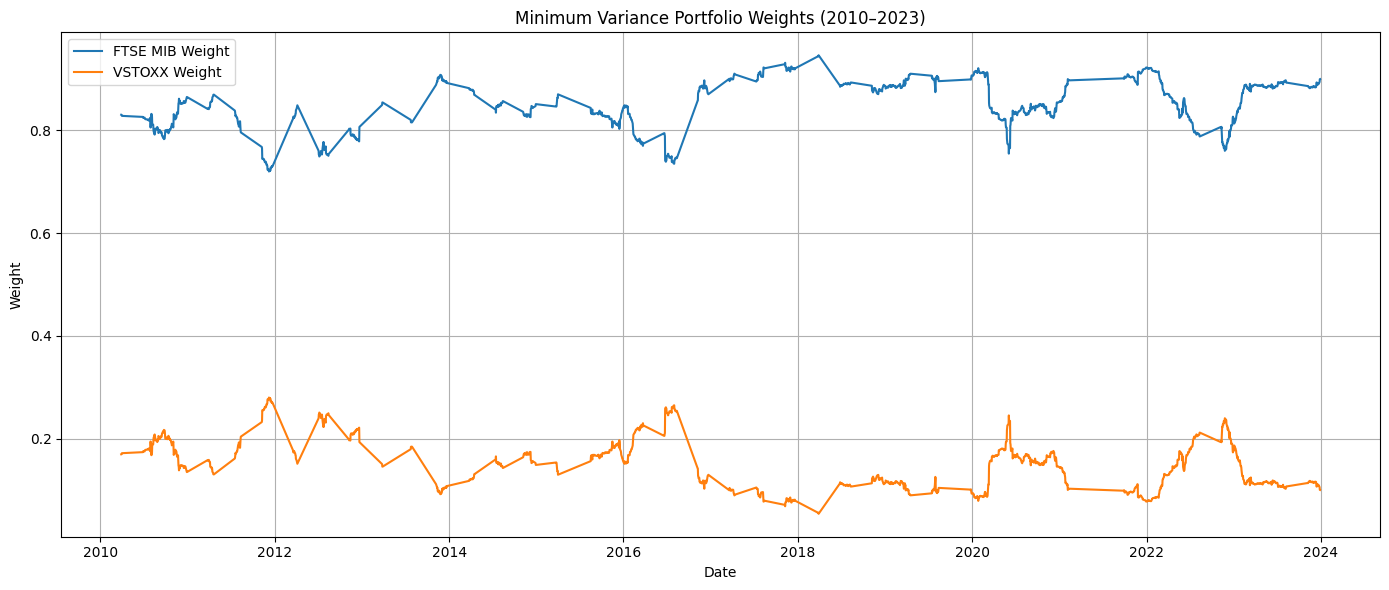

In [52]:
plt.figure(figsize=(14, 6))
plt.plot(weights_df.index, weights_df['FTSE_MIB_weight'], label='FTSE MIB Weight')
plt.plot(weights_df.index, weights_df['VSTOXX_weight'], label='VSTOXX Weight')
plt.title('Minimum Variance Portfolio Weights (2010–2023)')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('weights_plot.png')  # Save for Overleaf
plt.show()


VaR vs actual returns

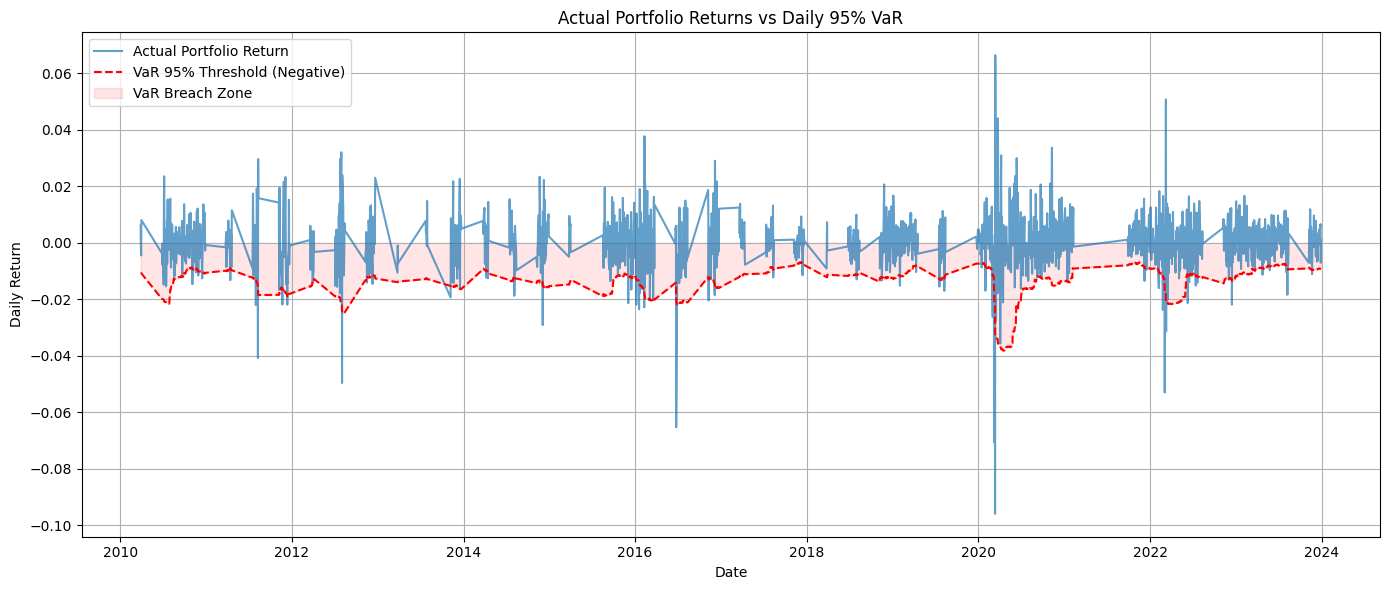

In [40]:
# Compute actual portfolio returns from weights and asset returns
portfolio_returns = (
    weights_df['FTSE_MIB_weight'].values * train_returns.loc[weights_df.index, 'FTSE_MIB'].values +
    weights_df['VSTOXX_weight'].values * train_returns.loc[weights_df.index, 'VSTOXX'].values
)

# Add returns to risk_df for plotting
risk_df['Portfolio_Return'] = portfolio_returns

# Plotting VaR vs actual returns
plt.figure(figsize=(14, 6))
plt.plot(risk_df.index, risk_df['Portfolio_Return'], label='Actual Portfolio Return', alpha=0.7)
plt.plot(risk_df.index, -risk_df['VaR_95'], label='VaR 95% Threshold (Negative)', color='red', linestyle='--')
plt.fill_between(risk_df.index, -risk_df['VaR_95'], 0, color='red', alpha=0.1, label='VaR Breach Zone')

plt.title('Actual Portfolio Returns vs Daily 95% VaR')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Design Stress Scenarios

In [41]:
# Parameters
window_size = 20  # lookback window for recent market condition
stress_vol_multiplier = 3  # amplify recent volatility
num_scenarios = 1  # can increase if you want multiple scenarios

# Store simulated stress returns
stress_returns = []

for date in weights_df.index[window_size:]:
    try:
        # Extract recent window of returns
        recent_returns = train_returns.loc[:date].tail(window_size)

        # Estimate mean and std dev for each asset
        mu = recent_returns.mean().values  # 2 elements: FTSE, VSTOXX
        sigma = recent_returns.std().values * stress_vol_multiplier

        # Generate stress return for the date
        stress_r = np.random.normal(loc=mu, scale=sigma)

        stress_returns.append({
            'Date': date,
            'FTSE_MIB_stress_return': stress_r[0],
            'VSTOXX_stress_return': stress_r[1]
        })

    except Exception as e:
        print(f"Skipping {date} due to error: {e}")

# Convert to DataFrame
stress_df = pd.DataFrame(stress_returns).set_index('Date')


In [42]:
print(stress_df)

            FTSE_MIB_stress_return  VSTOXX_stress_return
Date                                                    
2010-07-20                0.006609             -0.441553
2010-07-21               -0.019007              0.091379
2010-07-22                0.061265              0.130552
2010-07-23                0.054199             -0.123378
2010-07-26                0.012838             -0.055943
...                            ...                   ...
2023-12-21               -0.017136              0.052586
2023-12-22                0.005692             -0.246825
2023-12-27                0.008157              0.017757
2023-12-28               -0.005276             -0.003150
2023-12-29               -0.021994             -0.057393

[1621 rows x 2 columns]


## Recompute Risk Under Stress

In [43]:
# Step 1: Align both DataFrames on the same date index
common_dates = weights_df.index.intersection(stress_df.index)

# Step 2: Subset to common dates
weights_aligned = weights_df.loc[common_dates]
stress_aligned = stress_df.loc[common_dates]

# Step 3: Compute stress portfolio returns using aligned data
stress_portfolio_returns = (
    weights_aligned['FTSE_MIB_weight'].values * stress_aligned['FTSE_MIB_stress_return'].values +
    weights_aligned['VSTOXX_weight'].values * stress_aligned['VSTOXX_stress_return'].values
)

# Step 4: Create result DataFrame
stress_portfolio_df = pd.DataFrame({
    'Date': common_dates,
    'Stress_Portfolio_Return': stress_portfolio_returns
}).set_index('Date')

# Step 5: Compute rolling std, VaR, and ES
window_size = 20
from scipy.stats import norm

alpha = 0.95
z = norm.ppf(1 - alpha)

stress_portfolio_df['Stress_Std'] = stress_portfolio_df['Stress_Portfolio_Return'].rolling(window_size).std()
stress_portfolio_df['Stress_VaR_95'] = -z * stress_portfolio_df['Stress_Std']
stress_portfolio_df['Stress_ES_95'] = stress_portfolio_df['Stress_Std'] * norm.pdf(z) / (1 - alpha)

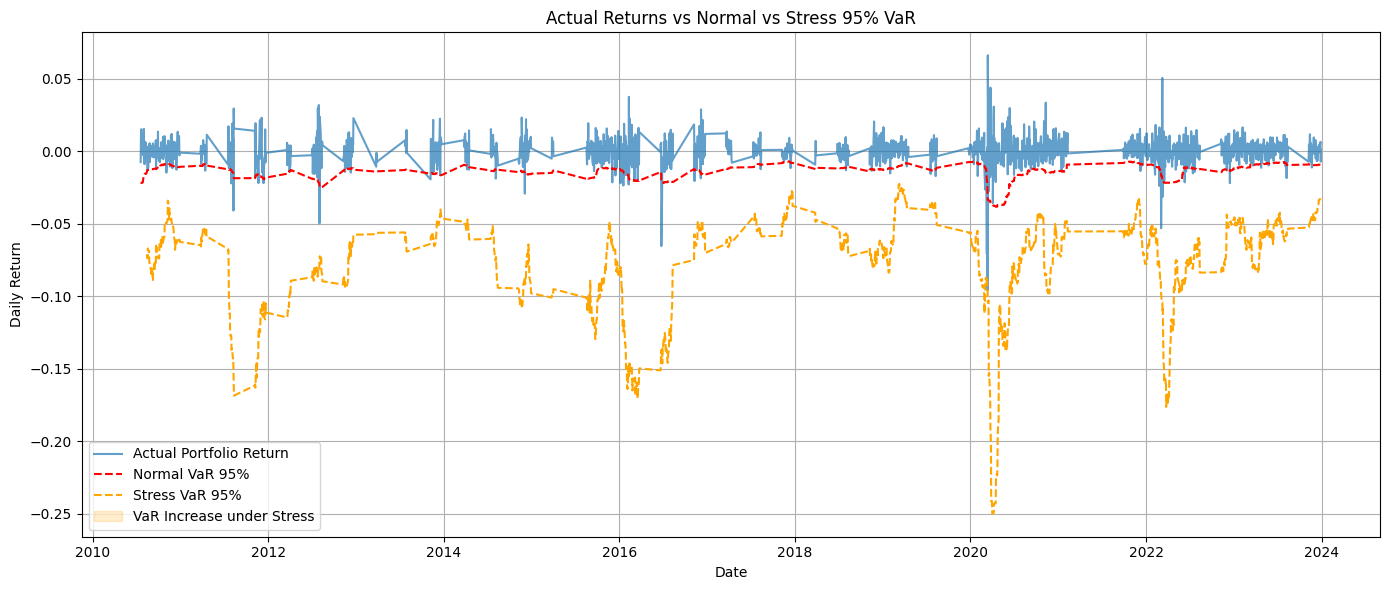

In [44]:
# Align on common dates
common_dates = risk_df.index.intersection(stress_portfolio_df.index)

# Extract aligned series
actual_returns = risk_df.loc[common_dates, 'Portfolio_Return']
normal_var = -risk_df.loc[common_dates, 'VaR_95']
stress_var = -stress_portfolio_df.loc[common_dates, 'Stress_VaR_95']

# Plot
plt.figure(figsize=(14, 6))
plt.plot(common_dates, actual_returns, label='Actual Portfolio Return', alpha=0.7)
plt.plot(common_dates, normal_var, label='Normal VaR 95%', linestyle='--', color='red')
plt.plot(common_dates, stress_var, label='Stress VaR 95%', linestyle='--', color='orange')

plt.fill_between(common_dates, normal_var, stress_var, where=(stress_var > normal_var),
                 color='orange', alpha=0.2, label='VaR Increase under Stress')

plt.title('Actual Returns vs Normal vs Stress 95% VaR')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model Evaluation and Backtesting

## Apply Model to 2024–2025

In [45]:
# Step 1: Compute rolling covariance matrices on the test set
window_size = 60  # or whatever you used during training
rolling_cov_test = test_returns.rolling(window=window_size).cov().dropna()

# Step 2: Compute minimum variance weights each day
test_weights = []
unique_test_dates = rolling_cov_test.index.get_level_values(0).unique()

for date in unique_test_dates:
    try:
        # Extract the 2x2 covariance matrix for this date
        cov_block = rolling_cov_test.loc[date]
        cov_matrix = cov_block.values.astype(float)

        if cov_matrix.shape != (2, 2):
            continue  # skip if incomplete

        # Compute minimum variance weights
        ones = np.ones((2, 1))
        inv_cov = np.linalg.inv(cov_matrix)
        weights = (inv_cov @ ones) / (ones.T @ inv_cov @ ones)

        test_weights.append({
            'Date': date,
            'FTSE_MIB_weight': weights[0, 0],
            'VSTOXX_weight': weights[1, 0]
        })

    except Exception as e:
        print(f"Skipping {date} due to error: {e}")

# Step 3: Create weights DataFrame
test_weights_df = pd.DataFrame(test_weights).set_index('Date')

# Step 4: Compute portfolio returns using the test returns and weights
aligned_test_returns = test_returns.loc[test_weights_df.index]

portfolio_returns_test = (
    test_weights_df['FTSE_MIB_weight'].values * aligned_test_returns['FTSE_MIB'].values +
    test_weights_df['VSTOXX_weight'].values * aligned_test_returns['VSTOXX'].values
)

# Step 5: Simulate portfolio value over time
initial_value = 1000
portfolio_value = [initial_value]

for r in portfolio_returns_test:
    next_value = portfolio_value[-1] * (1 + r)
    portfolio_value.append(next_value)

# Step 6: Assemble results into a DataFrame
test_results_df = pd.DataFrame({
    'Portfolio_Return': portfolio_returns_test,
    'Portfolio_Value': portfolio_value[1:],  # exclude the initial value
    'FTSE_MIB_weight': test_weights_df['FTSE_MIB_weight'],
    'VSTOXX_weight': test_weights_df['VSTOXX_weight']
}, index=test_weights_df.index)

# Done
test_results_df.head()


,Portfolio_Return,Portfolio_Value,FTSE_MIB_weight,VSTOXX_weight
Date,,,,
2024-03-25,0.008330,1008.329557,0.911966,0.088034
2024-03-26,0.000974,1009.311666,0.904574,0.095426
2024-03-27,0.004697,1014.051981,0.915059,0.084941
2024-03-28,0.003107,1017.202151,0.916652,0.083348
2024-04-02,0.000512,1017.722759,0.913177,0.086823


##  Backtest VaR and ES

In [46]:
# Parameters
alpha = 0.95
z = norm.ppf(1 - alpha)  # ≈ -1.64485
window_size = 60  # same rolling window used in training

# Step 1: Compute rolling standard deviation of returns
test_results_df['Rolling_Std'] = test_results_df['Portfolio_Return'].rolling(window_size).std()

# Step 2: Compute VaR and ES
test_results_df['VaR_95'] = -z * test_results_df['Rolling_Std']
test_results_df['ES_95'] = test_results_df['Rolling_Std'] * norm.pdf(z) / (1 - alpha)

# Step 3: Flag violations (actual return worse than −VaR)
test_results_df['VaR_Violation'] = test_results_df['Portfolio_Return'] < -test_results_df['VaR_95']

# Optional: Count total violations and expected violations
total_observations = test_results_df['VaR_95'].dropna().shape[0]
expected_violations = (1 - alpha) * total_observations
actual_violations = test_results_df['VaR_Violation'].sum()


### Plot Result

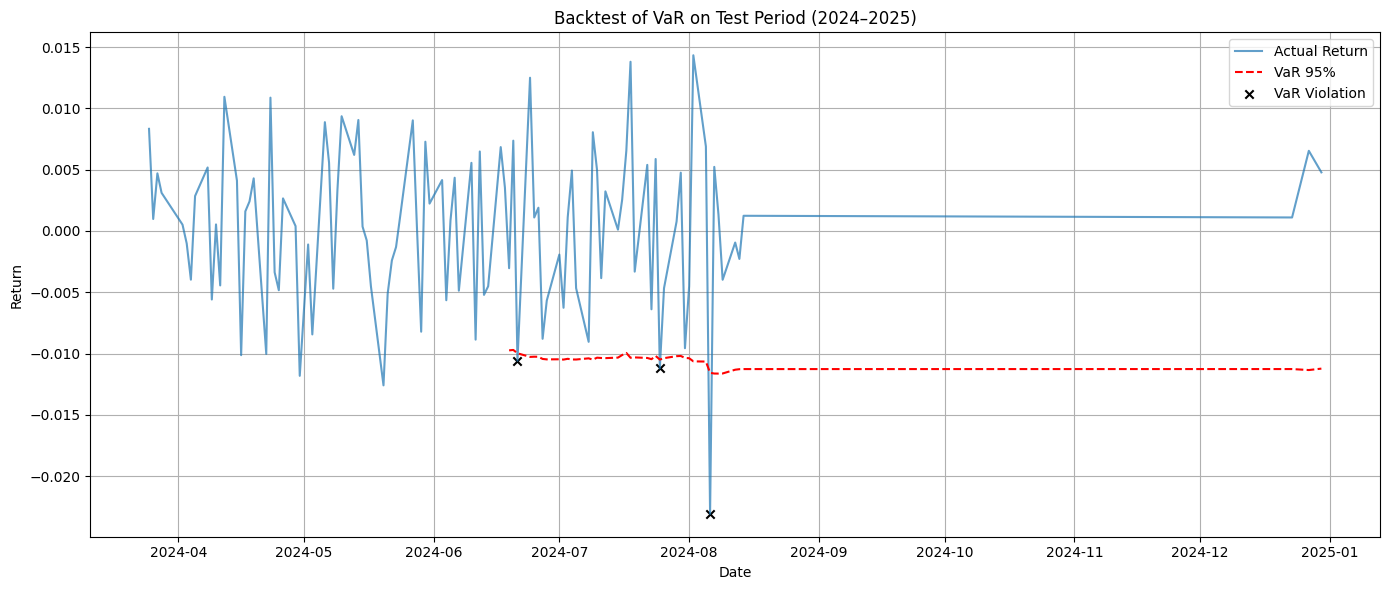

In [47]:
plt.figure(figsize=(14, 6))
plt.plot(test_results_df.index, test_results_df['Portfolio_Return'], label='Actual Return', alpha=0.7)
plt.plot(test_results_df.index, -test_results_df['VaR_95'], label='VaR 95%', linestyle='--', color='red')
plt.scatter(test_results_df.index[test_results_df['VaR_Violation']],
            test_results_df['Portfolio_Return'][test_results_df['VaR_Violation']],
            color='black', marker='x', label='VaR Violation')

plt.title('Backtest of VaR on Test Period (2024–2025)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Analyze Performance

### Simulate Stress Returns

In [48]:
# Rolling window and multiplier for stress
window_size = 20
stress_vol_multiplier = 3

stress_returns_test = []

for date in test_weights_df.index[window_size:]:
    try:
        window = test_returns.loc[:date].tail(window_size)
        mu = window.mean().values
        sigma = window.std().values * stress_vol_multiplier
        stress_r = np.random.normal(loc=mu, scale=sigma)

        stress_returns_test.append({
            'Date': date,
            'FTSE_MIB_stress_return': stress_r[0],
            'VSTOXX_stress_return': stress_r[1]
        })

    except Exception as e:
        print(f"Skipping {date} due to error: {e}")

stress_df_test = pd.DataFrame(stress_returns_test).set_index('Date')


### Compute Stress Portfolio Returns

In [49]:
# Align dates
common_test_dates = test_weights_df.index.intersection(stress_df_test.index)
weights_test_aligned = test_weights_df.loc[common_test_dates]
stress_test_aligned = stress_df_test.loc[common_test_dates]

# Compute stress-period portfolio returns
stress_port_returns_test = (
    weights_test_aligned['FTSE_MIB_weight'].values * stress_test_aligned['FTSE_MIB_stress_return'].values +
    weights_test_aligned['VSTOXX_weight'].values * stress_test_aligned['VSTOXX_stress_return'].values
)

stress_port_df = pd.DataFrame({
    'Stress_Portfolio_Return': stress_port_returns_test
}, index=common_test_dates)

# Rolling std and VaR/ES
from scipy.stats import norm

z = norm.ppf(1 - 0.95)
stress_port_df['Stress_Std'] = stress_port_df['Stress_Portfolio_Return'].rolling(window_size).std()
stress_port_df['Stress_VaR_95'] = -z * stress_port_df['Stress_Std']
stress_port_df['Stress_ES_95'] = stress_port_df['Stress_Std'] * norm.pdf(z) / (1 - 0.95)

###  Compare with Normal Model VaR/ES

In [50]:
# Align with normal VaR/ES (from test_results_df)
comparison_dates = test_results_df.index.intersection(stress_port_df.index)

# Final comparison DataFrame
var_comparison_df = pd.DataFrame({
    'Normal_VaR_95': -test_results_df.loc[comparison_dates, 'VaR_95'],
    'Stress_VaR_95': stress_port_df.loc[comparison_dates, 'Stress_VaR_95'],
    'Normal_ES_95': test_results_df.loc[comparison_dates, 'ES_95'],
    'Stress_ES_95': stress_port_df.loc[comparison_dates, 'Stress_ES_95']
}, index=comparison_dates)


### Plot the Comparison

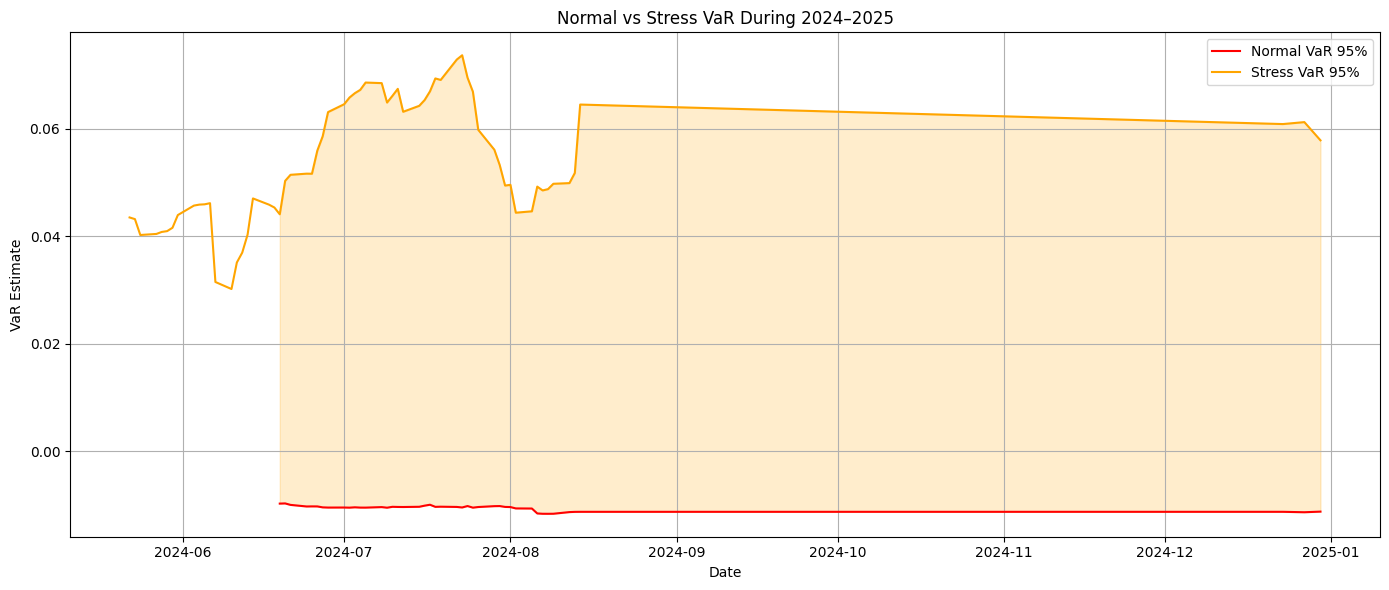

In [51]:

plt.figure(figsize=(14, 6))
plt.plot(var_comparison_df.index, var_comparison_df['Normal_VaR_95'], label='Normal VaR 95%', color='red')
plt.plot(var_comparison_df.index, var_comparison_df['Stress_VaR_95'], label='Stress VaR 95%', color='orange')
plt.fill_between(var_comparison_df.index,
                 var_comparison_df['Normal_VaR_95'],
                 var_comparison_df['Stress_VaR_95'],
                 where=(var_comparison_df['Stress_VaR_95'] > var_comparison_df['Normal_VaR_95']),
                 color='orange', alpha=0.2)

plt.title('Normal vs Stress VaR During 2024–2025')
plt.xlabel('Date')
plt.ylabel('VaR Estimate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()